<a href="https://colab.research.google.com/github/Tucker6742/CNN-sex-and-gender/blob/main/CNN_Sex_and_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Import kaggle and import dataset}$


## $\text{Kaggle JSON}$

In [ ]:
!gdown https://drive.google.com/drive/folders/1hD77y2Ircm2H7c9FUgwPBwbxiFfB0v0a?usp=share_link --folder --fuzzy -O "/content/ML-AI 2"

Retrieving folder list
Processing file 19KNLUykCcTci810FpX5uxeyvYh8fNH68 kaggle.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=19KNLUykCcTci810FpX5uxeyvYh8fNH68
To: /content/ML-AI 2/kaggle.json
100% 66.0/66.0 [00:00<00:00, 76.2kB/s]
Download completed


## $\text{Model check point}$

In [ ]:
!gdown https://drive.google.com/drive/folders/1Vjmp-JStN5dAVnOOwtvEyisW3hb6rsyq?usp=sharing --folder --fuzzy -O "/content/Checkpoint"

Retrieving folder list
Processing file 1Z_6h3X5gVkjkqVn-UrgRVvlW_WiX5E9i best_model.pth
Processing file 1TliFl91fs3W46zTNZ0TXjbQuc_R1n3Qc model2_9_vgg19.pth
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Z_6h3X5gVkjkqVn-UrgRVvlW_WiX5E9i
To: /content/Checkpoint/best_model.pth
100% 1.12G/1.12G [00:11<00:00, 95.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TliFl91fs3W46zTNZ0TXjbQuc_R1n3Qc
To: /content/Checkpoint/model2_9_vgg19.pth
100% 1.12G/1.12G [00:17<00:00, 64.8MB/s]
Download completed


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/ML-AI 2/kaggle.json" ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 92% 305M/331M [00:02<00:00, 152MB/s]
100% 331M/331M [00:02<00:00, 164MB/s]


In [ ]:
!unzip -qq /content/utkface-new.zip -d /content/kaggle

# $\text{Connect to other drive}$

In [ ]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser 
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

# $\text{Import library}$


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
from PIL import Image

## $\text{Info of model function}$
- Module : Rather than using the Sequential
- PyTorch class to implement LeNet, we’ll instead subclass the Module object so you can see how PyTorch implements neural networks using classes
- Conv2d : PyTorch’s implementation of convolutional layers
- Linear : Fully connected layers
- MaxPool2d : Applies 2D max-pooling to reduce the spatial dimensions of the input volume
- ReLU : Our ReLU activation function
- LogSoftmax : Used when building our softmax classifier to return the predicted probabilities of each class
- flatten : Flattens the output of a multi-dimensional volume (e.g., a CONV or POOL layer) such that we can apply fully connected layers to it




In [ ]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torchsummary import summary
from torchvision.models import vgg19, VGG19_Weights

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold as kfold
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import SGD, Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split as split_class_even
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
base_path = "/content/kaggle/UTKFace/"
base_path2 = "/content/kaggle/crop_part1"
base_path3 = "/content/kaggle/utkface_aligned_cropped"
base_path4 = "/content/Tests/"
files = os.listdir(base_path)
# files2 = os.listdir(base_path2)
# files3 = os.listdir(base_path3)
# files4 = os.listdir(base_path4)
len(files)
# len(files2)
# len(files3)

23708

In [ ]:
def age_split(x): 
    return min(x//5, 19)

## $\text{Read BW img}$

In [ ]:
images = []
ages = []
genders = []
age_data = []
gender_data = []
for i, items in enumerate(files):
    # print(base_path+items)
    info = items.split("_")
    image = cv2.imread(base_path+items,0)
    image = cv2.resize(image,dsize=(64, 64))
    image = image/255
    image = image.reshape((1, image.shape[0],image.shape[1]))
    images.append(image)
    age = int(info[0])
    # print(i)
    # print(age, age_split(age))
    age_data.append(age_split(age))
 

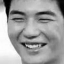

In [ ]:
images = np.array(images)
images.shape
cv2_imshow(images[0].reshape(64, 64, 1)*255)

## $\text{Read RGB img}$

In [ ]:
preprocess = VGG19_Weights.IMAGENET1K_V1.transforms()
preprocess.resize_size = 70
preprocess.crop_size = 70

images = []
ages = []
genders = []
age_data = []
gender_data = []
for i, items in enumerate(files):
    # print(base_path+items)
    info = items.split("_")
    age = int(info[0])
    age_data.append(age_split(age))
    image = Image.open(base_path+items)
    # image = cv2.resize(image,dsize=(64, 64))
    # image = image/255
    # image = image.reshape((1, image.shape[0],image.shape[1]))
    # print(i)
    # print(age, age_split(age))
    image = preprocess(image)
    images.append(image)
    # image = None
    # del image
    # gc.collect()

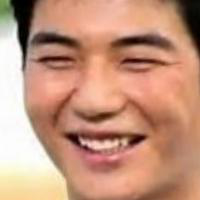

In [ ]:
Image.open(base_path+files[0]).show()

# $\text{Reset model and data}$

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
test_model, optimizer = [None]*2
x_val_fold, y_val_fold, x_train_fold, y_train_fold = [None]*4
x_age_train, y_age_train, x_age_test, y_age_test = [None]*4
inputs, output, loss, labels = [None]*4
data_train, data_val, dataloader, val_loader = [None]*4
import gc
gc.collect()
del test_model, optimizer
del  x_val_fold, y_val_fold, x_train_fold, y_train_fold
del x_age_train, y_age_train, x_age_test, y_age_test
del inputs, output, loss, labels
del data_train, data_val, dataloader, val_loader
gc.collect()

0

# $\text{Setup split data}$

## $\text{Check data distribution}$

In [ ]:
ele, count = np.unique(age_data, return_counts=True)
ele, count

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([2167,  895,  589,  942, 2310, 5034, 2290, 2247, 1181, 1064, 1345,
         954,  732,  586,  373,  326,  237,  267,  102,   67]))

## $\text{Set split count}$

In [ ]:
(TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT) = (0.8, 0.1, 0.1)
# num_train = int(len(age_data)*TRAIN_SPLIT)
# num_val = int(len(age_data)*VAL_SPLIT)
# num_test = int(len(age_data)*TEST_SPLIT)

## $\text{Split stratify}$

In [ ]:
x_age_train, x_age_test, y_age_train, y_age_test = split_class_even(images, age_data, train_size = TRAIN_SPLIT+VAL_SPLIT, shuffle = True, stratify = age_data, random_state = 27)
x_age_train = torch.stack(x_age_train).type(torch.float).to("cuda")
y_age_train = torch.tensor(y_age_train).type(torch.float).to("cuda")
x_age_test = torch.stack(x_age_test).type(torch.float).to("cuda")
y_age_test = torch.tensor(y_age_test).type(torch.float).to("cuda")

In [ ]:
x_age_train.shape, y_age_train.shape

(torch.Size([21337, 3, 70, 70]), torch.Size([21337]))

In [ ]:
y_age_train.max(), y_age_train.min()

(tensor(19., device='cuda:0'), tensor(0., device='cuda:0'))

In [ ]:
ele, count = torch.unique(y_age_train, return_counts=True)
ele2, count2 = torch.unique(y_age_test, return_counts=True)

In [ ]:
count, count2

(tensor([1950,  806,  530,  848, 2079, 4531, 2061, 2022, 1063,  958, 1210,  859,
          659,  527,  336,  293,  213,  240,   92,   60], device='cuda:0'),
 tensor([217,  89,  59,  94, 231, 503, 229, 225, 118, 106, 135,  95,  73,  59,
          37,  33,  24,  27,  10,   7], device='cuda:0'))

## $\text{Setup weight Cross Entropy loss}$

In [ ]:
sqrt_ele = torch.sqrt(torch.max(count)*torch.min(count))
min_arg = torch.argmin(torch.abs(count-sqrt_ele))
weight_cel = count[min_arg]/count
weight_cel

tensor([0.2703, 0.6538, 0.9943, 0.6215, 0.2535, 0.1163, 0.2557, 0.2606, 0.4958,
        0.5501, 0.4355, 0.6135, 0.7997, 1.0000, 1.5685, 1.7986, 2.4742, 2.1958,
        5.7283, 8.7833], device='cuda:0')

# $\text{Make model}$

In [ ]:
INIT_LR = 0.0001
BATCH_SIZE = 32

## $\text{CNN}$

In [ ]:
from torch.nn.modules.dropout import Dropout
class CNN(Module):
	def __init__(self):
		# call the parent constructor
		super(CNN, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.relu = ReLU()
		self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3))
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		self.conv3 = Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3))
		self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		self.conv4 = Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=2)
		self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		self.conv5 = Conv2d(in_channels=256, out_channels=521, kernel_size=(3, 3))
		self.maxpool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=1024, out_features=512)
		self.fc3 = Linear(in_features=512, out_features=512)
		self.fc4 = Linear(in_features=512, out_features=256)
		self.fc5 = Linear(in_features=256, out_features=256)
		self.fc6 = Linear(in_features=256, out_features=128)
		self.fc7 = Linear(in_features=128, out_features=10)
		self.lsm = LogSoftmax(dim=1)
		self.do1 = Dropout(0.5)
		self.do2 = Dropout(0.5)
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu(x)
		x = self.maxpool2(x)
		x = self.do1(x)
		x = self.conv3(x)
		# x = self.relu(x)
		# x = self.maxpool3(x)


		# x = self.conv4(x)
		# x = self.relu(x)
		# x = self.maxpool4(x)
		# x = self.conv5(x)
		# x = self.relu(x)
		# x = self.maxpool5(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		shape = x.shape[1]
		x = Linear(in_features=shape, out_features=1024, device = "cuda")(x)
		x = self.relu(x)
		x = self.do2(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.do2(x)
		x = self.fc3(x)
		x = self.relu(x)
		x = self.do2(x)
		x = self.fc4(x)
		x = self.relu(x)
		x = self.do2(x)
		x = self.fc5(x)
		x = self.relu(x)
		x = self.do2(x)
		x = self.fc6(x)
		x = self.relu(x)
		x = self.fc7(x)
		# return the output predictions
		return x

# define training hyperparameters

# # test_model = CNN()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion = nn.MSELoss()
# optimizer = SGD(test_model.parameters(), lr = INIT_LR)
# test_model.to("cuda")

In [ ]:
x = CNN()
x.to("cuda")
summary(x, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             320
              ReLU-2           [-1, 32, 62, 62]               0
         MaxPool2d-3           [-1, 32, 31, 31]               0
            Conv2d-4          [-1, 128, 29, 29]          36,992
              ReLU-5          [-1, 128, 29, 29]               0
         MaxPool2d-6          [-1, 128, 14, 14]               0
           Dropout-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 12, 12]         295,168
              ReLU-9                 [-1, 1024]               0
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

## $\text{VGG19}$

In [ ]:
weights = VGG19_Weights.IMAGENET1K_V1
weights.get_state_dict(progress=True)

In [ ]:
vgg19_model = vgg19()
vgg19_model.classifier = nn.Sequential(
    nn.Flatten(),
    vgg19_model.classifier
)
vgg19_model.classifier[1][-1] = nn.Linear(in_features=4096, out_features=20, bias=True)


### $\text{Model achitecture}$

In [ ]:
vgg19_model

In [ ]:
summary(vgg19_model.to("cuda"), (3, 70, 70))

In [ ]:
vgg19_model(x_age_train[0:3]).argmax(1)

tensor([10,  5,  5], device='cuda:0')

# $\text{Start running age}$


In [ ]:
# test_model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_fold = 9

def main(mtype = "vgg",loaded = None, 
         optim = SGD, learn_rate = INIT_LR, crit = nn.CrossEntropyLoss(weight = weight_cel), 
         max_ep = 100, max_fd = max_fold):
    if mtype == "cnn":
      test_model = CNN()
    else:
      test_model = vgg19(weights = weights)
      test_model.classifier = nn.Sequential(
        nn.Flatten(),
        test_model.classifier
      )
      test_model.classifier[1][-1] = nn.Linear(in_features=4096, out_features=20, bias=True)
    test_model.to("cuda")
    optimizer = optim(test_model.parameters(), lr = learn_rate, momentum = 0.9)
    if loaded != None:
      test_model.load_state_dict(loaded["model_state_dict"])
      optimizer.load_state_dict(loaded["optimizer_state_dict"])
    best_acc = 0
    criterion = crit
    for epoch in range(max_ep):
        i = 1
        kf = kfold(n_splits = max_fd, shuffle=True)
        for train_index, val_index in kf.split(x_age_train.to("cpu"), y_age_train.to("cpu")):
            running_train_lost = 0.0
            running_val_lost = 0.0
            x_train_fold = x_age_train[train_index].to("cuda") 
            y_train_fold = y_age_train[train_index].to("cuda") 
            x_val_fold = x_age_train[val_index].to("cuda") 
            y_val_fold = y_age_train[val_index].to("cuda") 
            # print(y_train_fold.unique(return_counts=True))
            # print(y_val_fold.unique(return_counts=True))
            data_train = TensorDataset(x_train_fold, y_train_fold)
            data_val = TensorDataset(x_val_fold, y_val_fold)

            dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)
            print("Epoch", epoch+1)
            test_model.train()
            for inputs, labels in (dataloader):
                optimizer.zero_grad()
                outputs = (test_model(inputs).flatten(1))
                loss = criterion(outputs, labels.type(torch.LongTensor).to("cuda"))
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(test_model.parameters(), 5)
                optimizer.step()
                running_train_lost += loss.item()
                
            train_fold_loss = running_train_lost / len(dataloader)

            test_model.eval()
            with torch.inference_mode():
                for count, (inputs, labels) in enumerate(val_loader):
                    optimizer.zero_grad()
                    outputs = test_model(inputs).flatten(1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to("cuda"))
                    if count % 100 == 0:
                    #   print(inputs[:3])
                    #   print("Output")
                    #   print(outputs[:3])
                      print("Output prob")
                      print(torch.softmax(outputs[:3], 1))
                      print("Predict")
                      print(torch.argmax(outputs[:3], 1))
                      print("Labels")
                      print(labels[:3])
                      print("Loss")
                      print(loss.item())
                    running_val_lost += loss.item()
                val_fold_loss = running_val_lost / len(val_loader)
                print('Fold [{}/{}], Train Loss: {:.4f}'.format(i, max_fold, train_fold_loss))
                print('Fold [{}/{}], Val Loss: {:.4f}\n'.format(i, max_fold, val_fold_loss))
            i += 1
        torch.save({"model_state_dict": test_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, f"/content/Checkpoint/model2_{epoch+1}.pth")
    
        data_test = TensorDataset(x_age_test, y_age_test)
        test_loader = DataLoader(data_test, batch_size=1)
        # optimizer = SGD(test_model.parameters(), lr = INIT_LR, momentum = 0.9)
        # criterion = nn.CrossEntropyLoss()

        predict = []
        real = []
        test_model.to("cuda")
        test_model.eval()
        running_test_lost = 0
        with torch.inference_mode():
            for inputs, labels in (test_loader):
                optimizer.zero_grad()
                outputs = (test_model(inputs.type(torch.float).to("cuda")))
                # print(torch.softmax(outputs, 1))
                # print(torch.argmax(torch.softmax(outputs, 1)).item(), int(labels.item()))
                predict.append(torch.argmax(torch.softmax(outputs, 1)).item())
                real.append(labels.item())
                loss = criterion(outputs, labels.type(torch.LongTensor).to("cuda"))
                # print(loss.item())
                running_test_lost += loss.item()
            test_fold_loss = running_test_lost / len(test_loader)
            print('Test Loss: {:.4f}\n'.format(test_fold_loss))
        age = pd.DataFrame(np.array([predict, real]).T, columns = ["Predict", "Actual"])

        # age
        x = ((np.diff(age.values)))
        age["Dif"] = x

        if best_acc < np.count_nonzero(x==0)/len(x):
            print(f"Old acc: {best_acc}, new acc {np.count_nonzero(x==0)/len(x)}")
            best_acc =  np.count_nonzero(x==0)/len(x)
            os.system(f'cp /content/Checkpoint/model2_{epoch+1}.pth "/content/gdrive/My Drive/Checkpoint/best_model.pth"')
        print("Accuracy")
        print(np.count_nonzero(x==0)/len(x))
        print(np.mean(x**2)**0.5)
    return (test_model, optimizer.state_dict())


In [ ]:
(test_model, optim_dict) = main()

In [ ]:
(test_model, optim_dict) = main(loaded = torch.load("/content/Checkpoint/model2_2.pth"))

# $\text{Export model}$

In [ ]:
torch.save({"model_state_dict": test_model.state_dict(),
            'optimizer_state_dict': optim_dict}, "/content/gdrive/My Drive/Checkpoint/best_model.pth")



In [ ]:
test_model = vgg19()
test_model.classifier = nn.Sequential(
        nn.Flatten(),
        test_model.classifier
      )
test_model.classifier[1][-1] = nn.Linear(in_features=4096, out_features=20, bias=True)

In [ ]:
cp = torch.load("/content/gdrive/My Drive/Checkpoint/best_model.pth")
test_model.load_state_dict(cp['model_state_dict'])

# test_model.state_dict()
data_test = TensorDataset(x_age_test, y_age_test)
test_loader = DataLoader(data_test, batch_size=1)
optimizer = SGD(test_model.parameters(), lr = INIT_LR, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

predict = []
real = []
test_model.to("cuda")
test_model.eval()
running_test_lost = 0
with torch.inference_mode():
    for inputs, labels in (test_loader):
        optimizer.zero_grad()
        outputs = (test_model(inputs.type(torch.float).to("cuda")))
        # print(torch.softmax(outputs, 1))
        # print(torch.argmax(torch.softmax(outputs, 1)).item(), int(labels.item()))
        predict.append(torch.argmax(torch.softmax(outputs, 1)).item())
        real.append(labels.item())
        loss = criterion(outputs, labels.type(torch.LongTensor).to("cuda"))
        # print(loss.item())
        running_test_lost += loss.item()
    test_fold_loss = running_test_lost / len(test_loader)
    print('Test Loss: {:.4f}\n'.format(test_fold_loss))
age = pd.DataFrame(np.array([predict, real]).T, columns = ["Predict", "Actual"])

# age
x = ((np.diff(age.values)))
age["Dif"] = x
print("Accuracy")
acc = np.count_nonzero(x==0)/len(x)
print(acc)
print(np.mean(x**2)**0.5)

# $\text{Conclude}$

In [ ]:
age.to_csv("/content/gdrive/My Drive/Checkpoint/result.csv",index = False)

In [ ]:
cfm = confusion_matrix(real, predict, labels=[i for i in range(20)])
cfm

In [ ]:
s = np.sum((cfm), 0)

In [ ]:
s

array([214,  79,  54,  65, 174, 636, 151, 375,  78,  62, 165,  77,  89,
        59,  25,  17,  12,  31,   2,   6])

In [ ]:
ratio = cfm/s

In [ ]:
ratio

In [ ]:
%matplotlib inline
# plt.rcParams["figure.figsize"] = (60,60)

# font = {'size': 30}
# plt.figure(facecolor='black')
# matplotlib.rc('font', **font)
# plt.xticks(fontsize=40)
# plt.yticks(fontsize=40)
# disp = ConfusionMatrixDisplay(confusion_matrix=ratio.round(3),display_labels=[i for i in range(20)])
# disp.plot()
# plt.savefig('/content/gdrive/My Drive/Checkpoint/foo.png', facecolor = "white", transparent = False)
# plt.show()
# print(ratio)
labels = [i for i in range(20)]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ratio)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(ratio, [i for i in range(20)],"VGG19 Confusion matrix","viridis")

In [ ]:
from google.colab import files
files.download('/content/Checkpoint/model2_9.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>